In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import sys
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-3843ysvc
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-3843ysvc
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done


In [3]:
HOME = "/content/drive/MyDrive/Projects/SAM_results"

In [4]:
import torch
import torchvision
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
import os
from os.path import join as pjoin
from sklearn.cluster import KMeans
import numpy.linalg as npLA

In [5]:
os.chdir(HOME)

In [6]:
def load_image(image_path):
    image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
    return image

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

def display_masked_image(image, x1, y1, x2, y2, dtype=np.int32, figsize=(5, 5)):
    h, w, c = image.shape
    masked_image = np.zeros((h, w, c), dtype=dtype)
    masked_image[y1:y2, x1:x2, :] = image[y1:y2, x1:x2, :]

    plt.figure(figsize=figsize)
    plt.imshow(masked_image)
    plt.axis('on')
    plt.show()

def morph_indexes(x1, y1, x2, y2, Yi, Xi, Yf, Xf):
    X1 = int(((Xf - 0)*(x1 - 0)) /(Xi - 0) + 0)
    X2 = int(((Xf - 0)*(x2 - 0)) /(Xi - 0) + 0)
    Y1 = int(((Yf - 0)*(y1 - 0)) /(Yi - 0) + 0)
    Y2 = int(((Yf - 0)*(y2 - 0)) /(Yi - 0) + 0)

    return (X1, Y1, X2, Y2)

In [7]:
import sys
sys.path.append("..")
# sys.path.append(HOME)
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

SAM_CHECKPOINT = pjoin(HOME, "sam_vit_h_4b8939.pth")
SAM_MODEL_TYPE = "vit_h"
SAM_DEVICE = "cuda"

In [8]:
class SAMExtractor:

    def __init__(self, model_checkpoint=SAM_CHECKPOINT, model_type=SAM_MODEL_TYPE, model_device=SAM_DEVICE):
        self.predictor = self._initialize_sam(model_checkpoint, model_type, model_device)

    def _initialize_sam(self, model_checkpoint, model_type, model_device):
        sam = sam_model_registry[model_type](checkpoint=model_checkpoint)
        sam.to(device=model_device)
        return SamPredictor(sam)

    def _get_mask_embedds(self, embedds, mask):
        x1, y1, x2, y2 = mask
        masked_embedds = embedds[:, :, y1:y2, x1:x2]
        gap2d_layer = torch.nn.AdaptiveAvgPool2d((1,1))
        return masked_embedds, gap2d_layer(masked_embedds)

    def get_sam_embedds(self, image, mask=None):
        self.predictor.set_image(image)
        embedds = self.predictor.get_image_embedding()
        display_masked_image(image, *mask)
        if mask == None:
            return embedds
        hi, wi, _ = image.shape
        _, _, hf, wf = embedds.shape
        new_mask = morph_indexes(*mask, *(hi, wi), *(hf, wf))
        new_image = cv2.resize(image, (hf, wf))
        display_masked_image(new_image, *new_mask)
        print(f"\n new mask = {new_mask}\n")
        return embedds, self._get_mask_embedds(embedds, new_mask)

In [9]:
predictor = SAMExtractor()
cos_sim = torch.nn.CosineSimilarity(dim=1)

## Truck Experiments

(1200, 1800, 3)


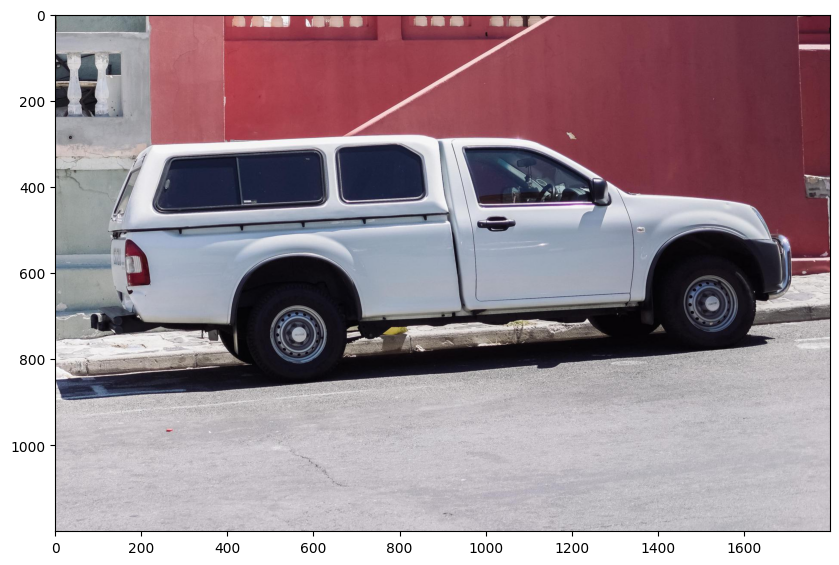

In [10]:
truck_img = load_image('assets/truck.jpg')
print(truck_img.shape)
plt.figure(figsize=(10,10))
plt.imshow(truck_img)

In [11]:
truck_img_resize = (1800, 1800)

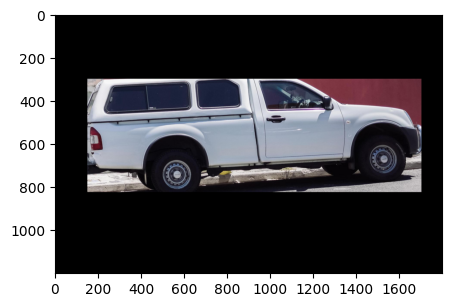

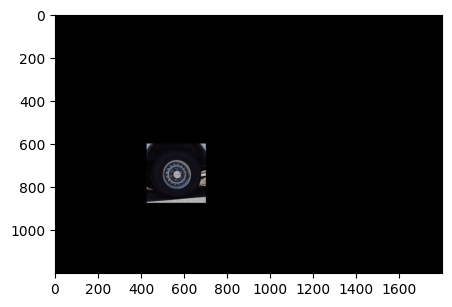

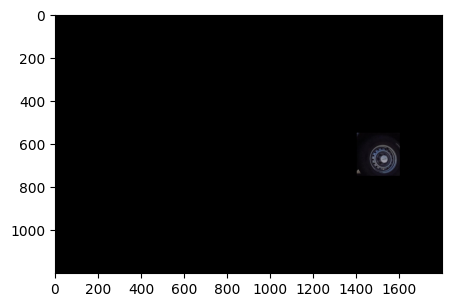

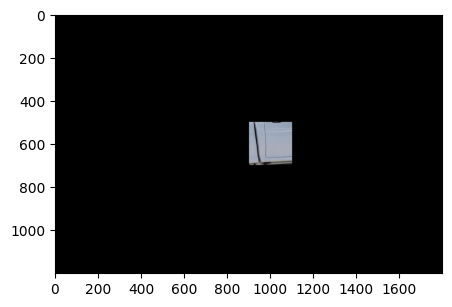

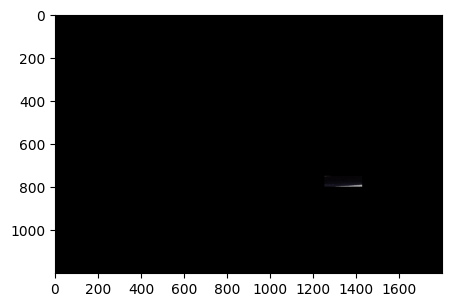

In [12]:
truck_bbox = [150, 300, 1700, 825]
ttire1_bbox = [425, 600, 700, 875]
ttire2_bbox = [1400, 550, 1600, 750]
ttire3_bbox = [1250,750, 1425,800]
truck_body_bbox = [900,500,1100, 700]

tbboxes = [truck_bbox, ttire1_bbox, ttire2_bbox, truck_body_bbox, ttire3_bbox]

for bbox in tbboxes:
  display_masked_image(truck_img, *bbox)

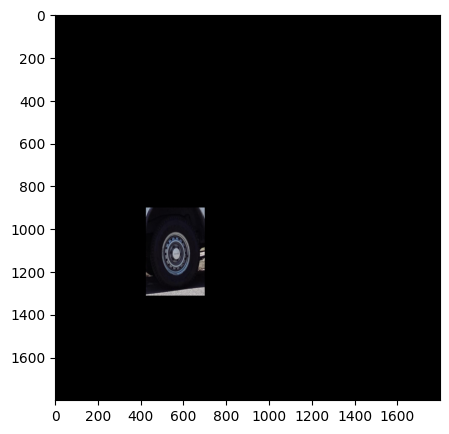

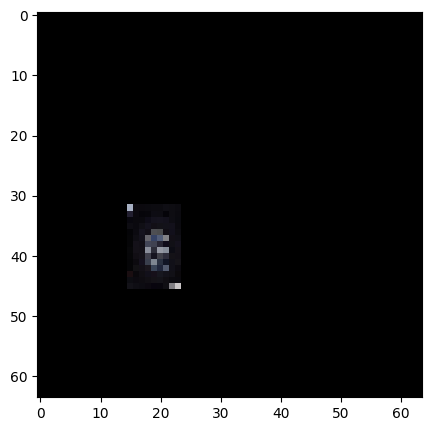


 new mask = (15, 32, 24, 46)



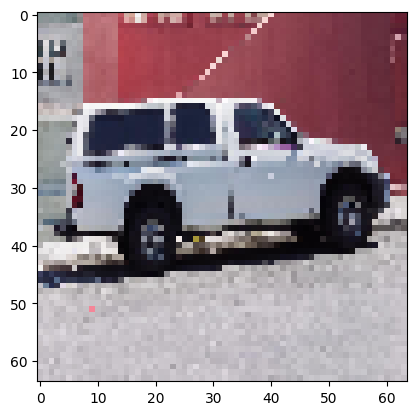

Shapes:
torch.Size([1, 256, 1, 1])
torch.Size([1, 256, 14, 9])
torch.Size([1, 256, 64, 64])
Embedds Check:


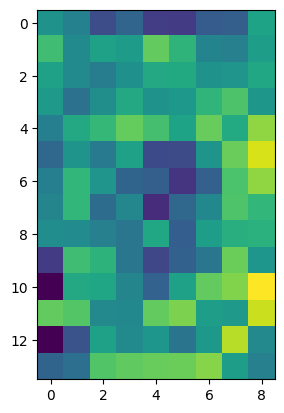

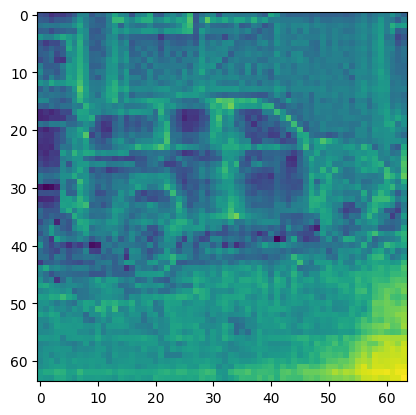

In [13]:
truck_img_em1, (ttire1_mask_em, ttire1_mask_em_avg) = predictor.get_sam_embedds(cv2.resize(truck_img, truck_img_resize), morph_indexes(*ttire1_bbox, *truck_img.shape[:-1], *truck_img_resize))
plt.imshow(cv2.resize(truck_img, (64,64)))
plt.show()

print("Shapes:")
print(ttire1_mask_em_avg.shape)
print(ttire1_mask_em.shape)
print(truck_img_em1.shape)

print("Embedds Check:")
plt.imshow(torch.squeeze(torch.mean(ttire1_mask_em, dim=1)).detach().cpu().numpy())
plt.show()
plt.imshow(torch.squeeze(torch.mean(truck_img_em1, dim=1)).detach().cpu().numpy())
plt.show()

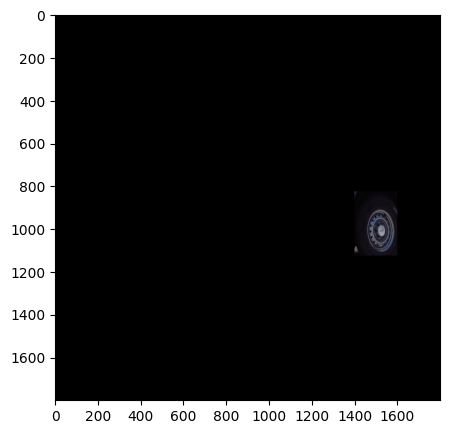

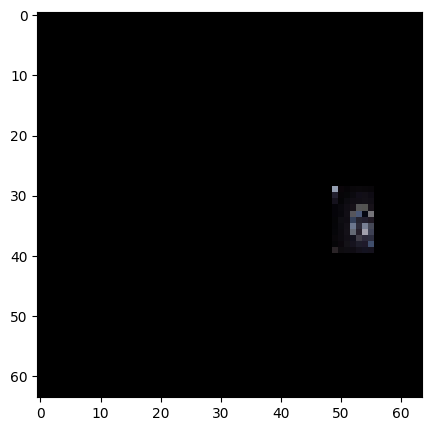


 new mask = (49, 29, 56, 40)



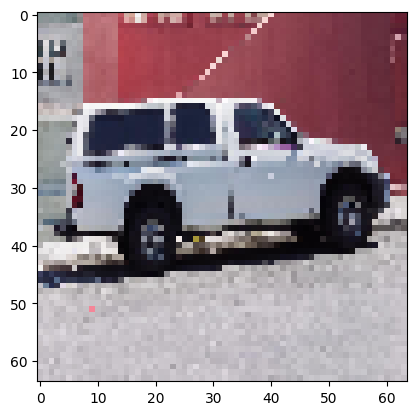

Shapes:
torch.Size([1, 256, 1, 1])
torch.Size([1, 256, 11, 7])
torch.Size([1, 256, 64, 64])
Embedds Check:


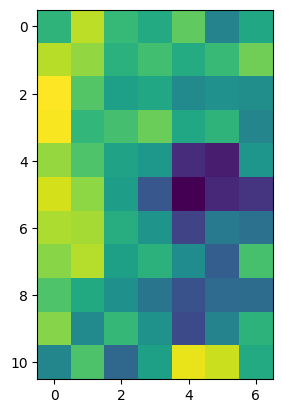

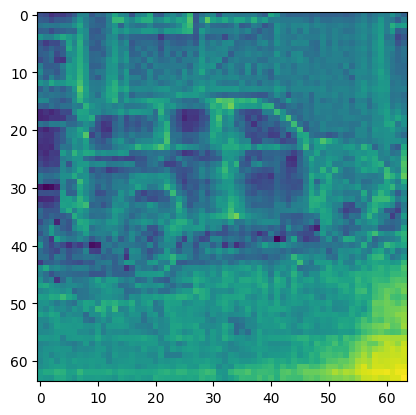

In [14]:
truck_img_em2, (ttire2_mask_em, ttire2_mask_em_avg) = predictor.get_sam_embedds(cv2.resize(truck_img, truck_img_resize), morph_indexes(*ttire2_bbox, *truck_img.shape[:-1], *truck_img_resize))
plt.imshow(cv2.resize(truck_img, (64,64)))
plt.show()

print("Shapes:")
print(ttire2_mask_em_avg.shape)
print(ttire2_mask_em.shape)
print(truck_img_em2.shape)

print("Embedds Check:")
plt.imshow(torch.squeeze(torch.mean(ttire2_mask_em, dim=1)).detach().cpu().numpy())
plt.show()
plt.imshow(torch.squeeze(torch.mean(truck_img_em2, dim=1)).detach().cpu().numpy())
plt.show()

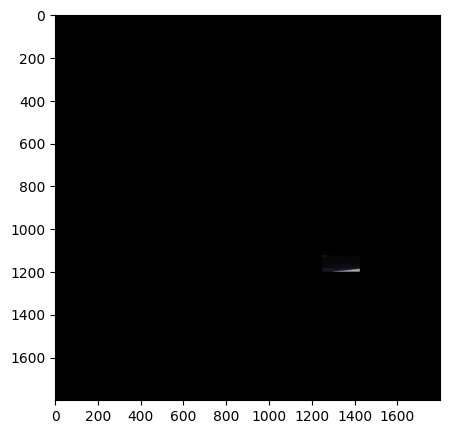

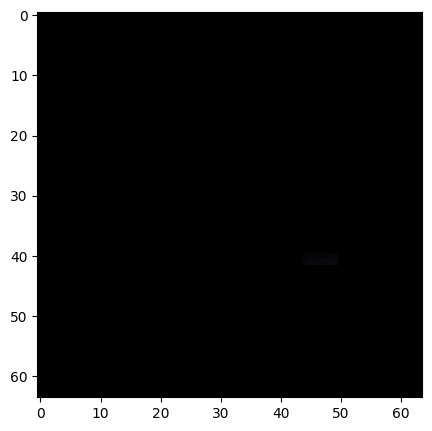


 new mask = (44, 40, 50, 42)



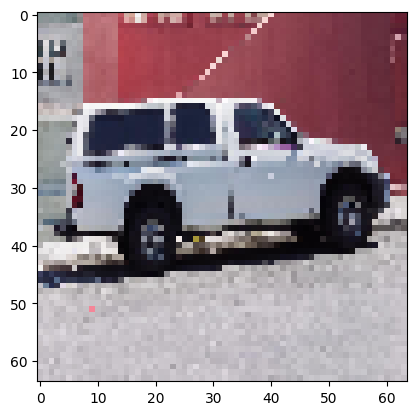

Shapes:
torch.Size([1, 256, 1, 1])
torch.Size([1, 256, 2, 6])
torch.Size([1, 256, 64, 64])
Embedds Check:


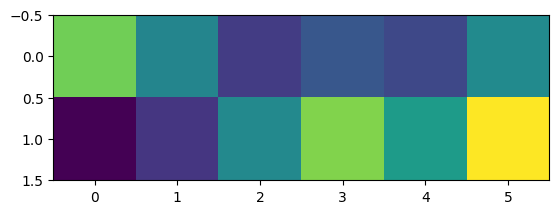

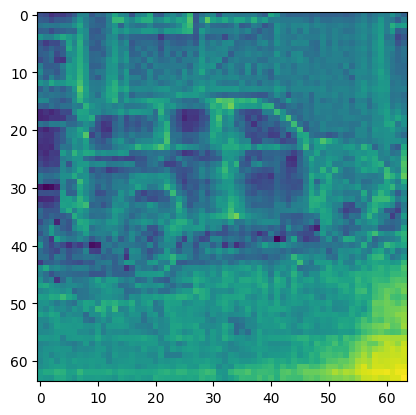

In [15]:
truck_img_em3, (ttire3_mask_em, ttire3_mask_em_avg) = predictor.get_sam_embedds(cv2.resize(truck_img, truck_img_resize), morph_indexes(*ttire3_bbox, *truck_img.shape[:-1], *truck_img_resize))
plt.imshow(cv2.resize(truck_img, (64,64)))
plt.show()

print("Shapes:")
print(ttire3_mask_em_avg.shape)
print(ttire3_mask_em.shape)
print(truck_img_em3.shape)

print("Embedds Check:")
plt.imshow(torch.squeeze(torch.mean(ttire3_mask_em, dim=1)).detach().cpu().numpy())
plt.show()
plt.imshow(torch.squeeze(torch.mean(truck_img_em3, dim=1)).detach().cpu().numpy())
plt.show()

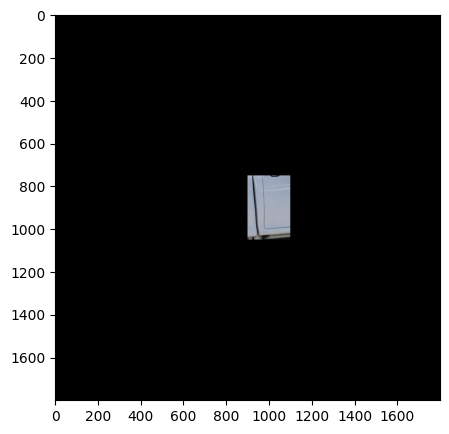

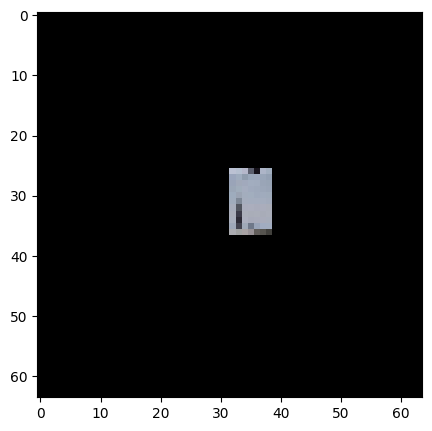


 new mask = (32, 26, 39, 37)



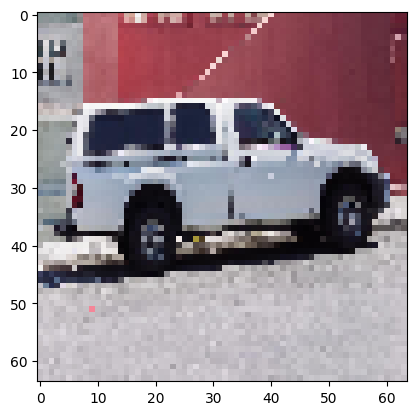

Shapes:
torch.Size([1, 256, 1, 1])
torch.Size([1, 256, 11, 7])
torch.Size([1, 256, 64, 64])
Embedds Check:


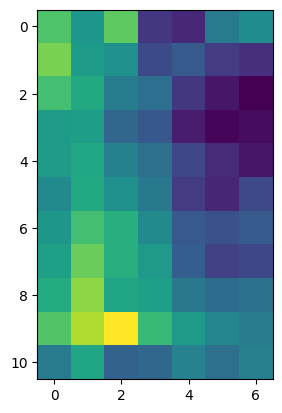

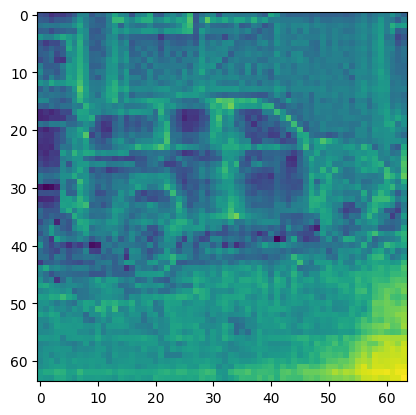

In [16]:
truck_img_em, (truck_body_mask_em, truck_body_mask_em_avg) = predictor.get_sam_embedds(cv2.resize(truck_img, truck_img_resize), morph_indexes(*truck_body_bbox, *truck_img.shape[:-1], *truck_img_resize))
plt.imshow(cv2.resize(truck_img, (64,64)))
plt.show()

print("Shapes:")
print(truck_body_mask_em_avg.shape)
print(truck_body_mask_em.shape)
print(truck_img_em.shape)

print("Embedds Check:")
plt.imshow(torch.squeeze(torch.mean(truck_body_mask_em, dim=1)).detach().cpu().numpy())
plt.show()
plt.imshow(torch.squeeze(torch.mean(truck_img_em, dim=1)).detach().cpu().numpy())
plt.show()

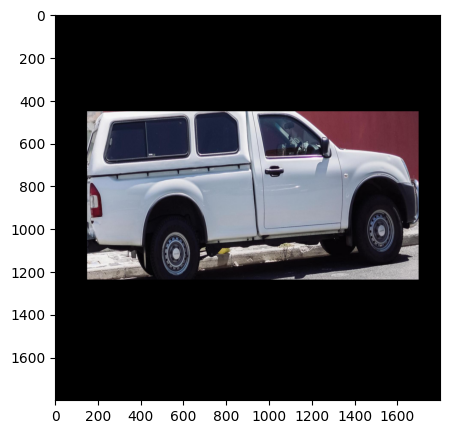

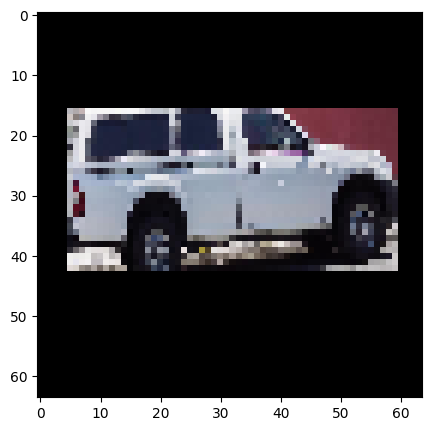


 new mask = (5, 16, 60, 43)



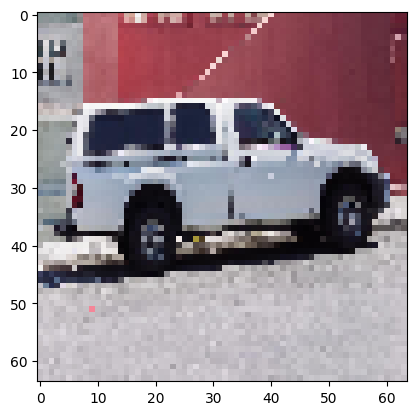

Shapes:
torch.Size([1, 256, 1, 1])
torch.Size([1, 256, 27, 55])
torch.Size([1, 256, 64, 64])
Embedds Check:


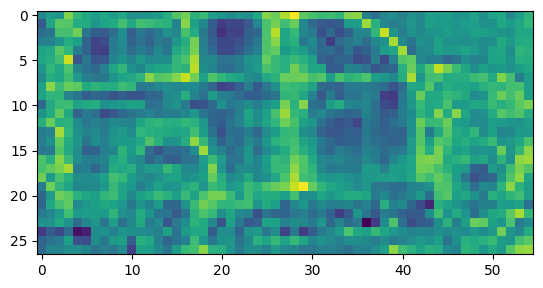

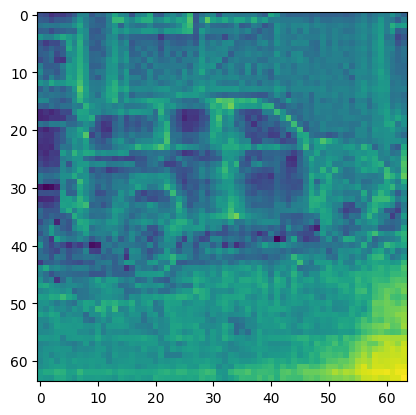

In [17]:
truck_img_em, (truck_mask_em, truck_mask_em_avg) = predictor.get_sam_embedds(cv2.resize(truck_img, truck_img_resize), morph_indexes(*truck_bbox, *truck_img.shape[:-1], *truck_img_resize))
plt.imshow(cv2.resize(truck_img, (64,64)))
plt.show()

print("Shapes:")
print(truck_mask_em_avg.shape)
print(truck_mask_em.shape)
print(truck_img_em.shape)

print("Embedds Check:")
plt.imshow(torch.squeeze(torch.mean(truck_mask_em, dim=1)).detach().cpu().numpy())
plt.show()
plt.imshow(torch.squeeze(torch.mean(truck_img_em, dim=1)).detach().cpu().numpy())
plt.show()

In [18]:
torch.equal(truck_img_em1, truck_img_em2)

True

torch.Size([64, 64])
tensor(0.8021, device='cuda:0') tensor(0.4309, device='cuda:0') tensor(-0.0664, device='cuda:0')


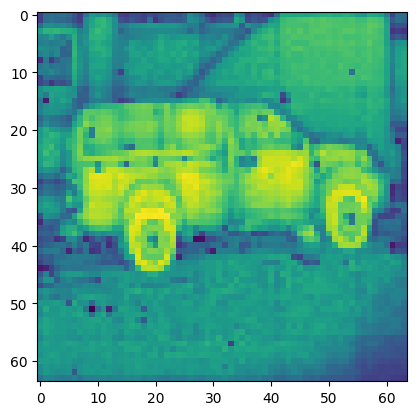

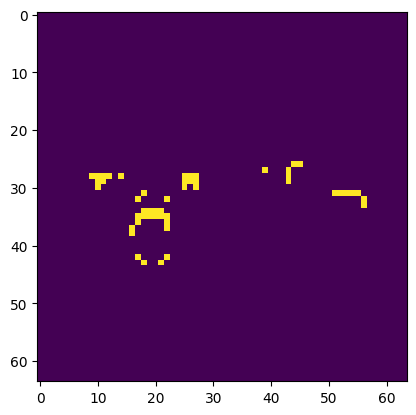

In [19]:
sim_map = torch.squeeze(cos_sim(ttire1_mask_em_avg, truck_img_em1))

print(sim_map.shape)
print(sim_map.max(), sim_map.mean(), sim_map.min())

plt.imshow(sim_map.detach().cpu().numpy())
plt.show()

plt.imshow(sim_map.detach().cpu().numpy()>0.75)

In [20]:
sim_map = torch.squeeze(cos_sim(ttire1_mask_em_avg, ttire2_mask_em_avg))

print(sim_map.shape)
print(sim_map.max(), sim_map.mean(), sim_map.min())

torch.Size([])
tensor(0.9161, device='cuda:0') tensor(0.9161, device='cuda:0') tensor(0.9161, device='cuda:0')


In [21]:
sim_map = torch.squeeze(cos_sim(ttire2_mask_em_avg, ttire3_mask_em_avg))

print(sim_map.shape)
print(sim_map.max(), sim_map.mean(), sim_map.min())

torch.Size([])
tensor(0.3222, device='cuda:0') tensor(0.3222, device='cuda:0') tensor(0.3222, device='cuda:0')


In [22]:
sim_map = torch.squeeze(cos_sim(truck_body_mask_em_avg, ttire2_mask_em_avg))

print(sim_map.shape)
print(sim_map.max(), sim_map.mean(), sim_map.min())

torch.Size([])
tensor(0.7560, device='cuda:0') tensor(0.7560, device='cuda:0') tensor(0.7560, device='cuda:0')


torch.Size([64, 64])
tensor(0.8917, device='cuda:0') tensor(0.4216, device='cuda:0') tensor(-0.2298, device='cuda:0')


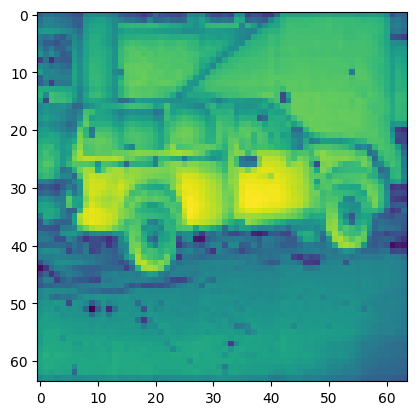

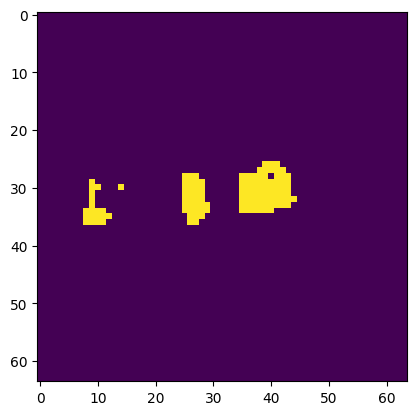

In [23]:
sim_map = torch.squeeze(cos_sim(truck_body_mask_em_avg, truck_img_em))

print(sim_map.shape)
print(sim_map.max(), sim_map.mean(), sim_map.min())

plt.imshow(sim_map.detach().cpu().numpy())
plt.show()
plt.imshow(sim_map.detach().cpu().numpy()>0.8)

## Tire Experiments

(3376, 6000, 3)


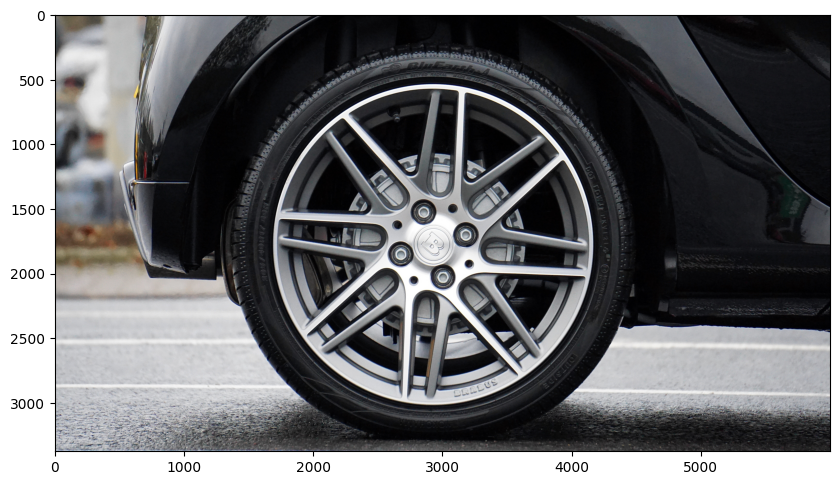

In [24]:
mt_img = load_image('assets/pexels-mike-bird-244553.jpg')
print(mt_img.shape)
plt.figure(figsize=(10,10))
plt.imshow(mt_img)

In [25]:
mt_img_resize = (3000,3000)

In [26]:
mt_bbox = [1500, 350, 4400, 3300]

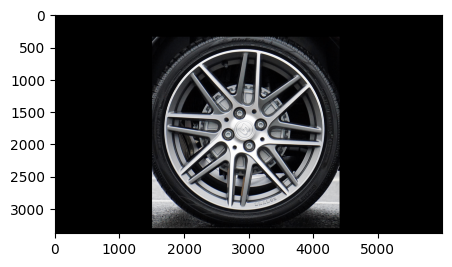

In [27]:
display_masked_image(mt_img, *mt_bbox)

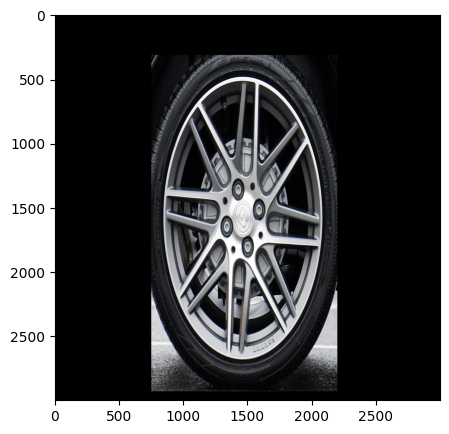

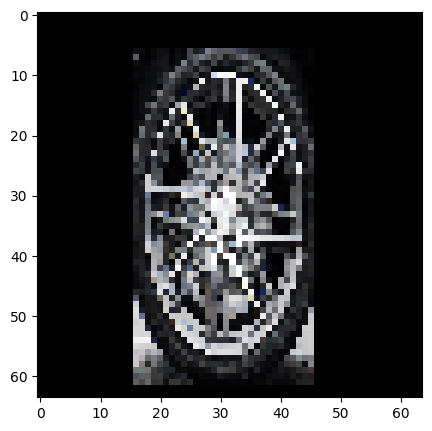


 new mask = (16, 6, 46, 62)



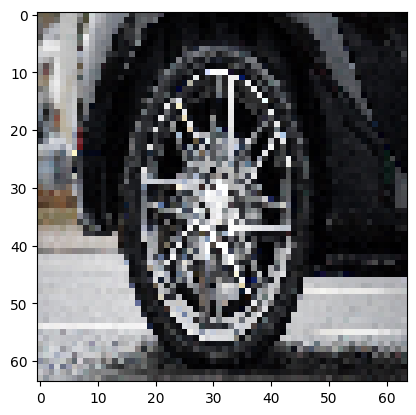

Shapes:
torch.Size([1, 256, 1, 1])
torch.Size([1, 256, 56, 30])
torch.Size([1, 256, 64, 64])
Embedds Check:


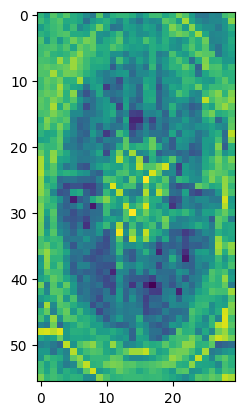

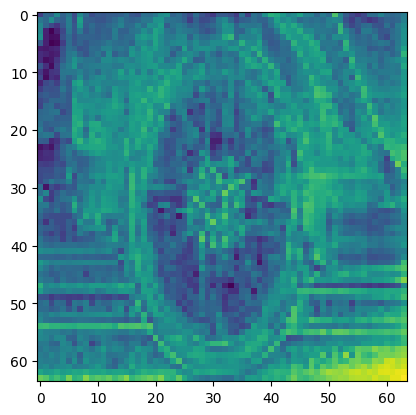

In [28]:
mt_img_em, (mt_mask_em, mt_mask_em_avg) = predictor.get_sam_embedds(cv2.resize(mt_img, mt_img_resize), morph_indexes(*mt_bbox, *mt_img.shape[:-1], *mt_img_resize))
plt.imshow(cv2.resize(mt_img, (64,64)))
plt.show()

print("Shapes:")
print(mt_mask_em_avg.shape)
print(mt_mask_em.shape)
print(mt_img_em.shape)

print("Embedds Check:")
plt.imshow(torch.squeeze(torch.mean(mt_mask_em, dim=1)).detach().cpu().numpy())
plt.show()
plt.imshow(torch.squeeze(torch.mean(mt_img_em, dim=1)).detach().cpu().numpy())
plt.show()

In [29]:
sim_map = torch.squeeze(cos_sim(mt_mask_em_avg, ttire1_mask_em_avg))

print(sim_map.shape)
print(sim_map.max(), sim_map.mean(), sim_map.min())

torch.Size([])
tensor(0.8611, device='cuda:0') tensor(0.8611, device='cuda:0') tensor(0.8611, device='cuda:0')


## Bugatti and Ferrari

(194, 259, 3)


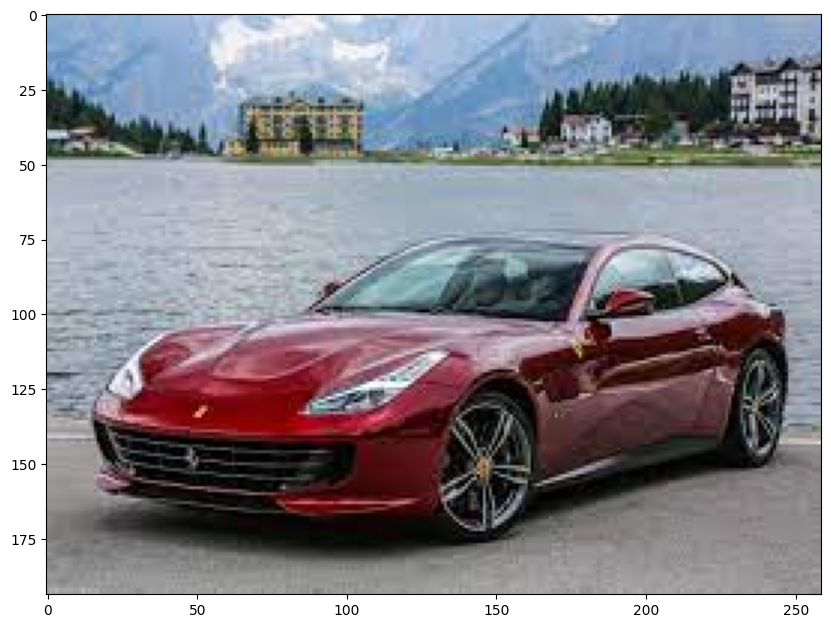

In [30]:
ferrari_img = load_image("assets/ferrari_car.jpg")

print(ferrari_img.shape)
plt.figure(figsize=(10,10))
plt.imshow(ferrari_img)

In [31]:
ferrari_img_resize = (250, 250)

In [32]:
ferrari_bbox = [20, 75, 245, 175]

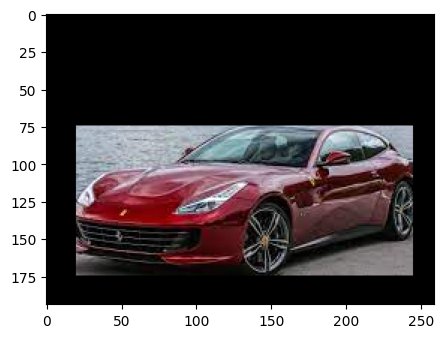

In [33]:
display_masked_image(ferrari_img, *ferrari_bbox)

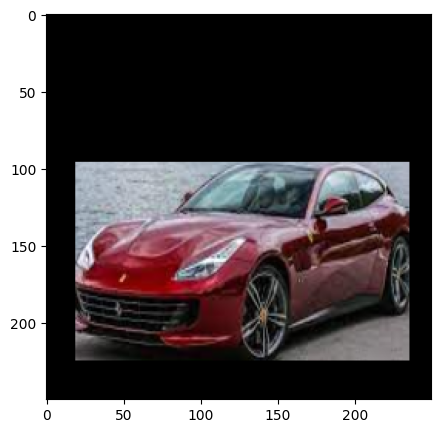

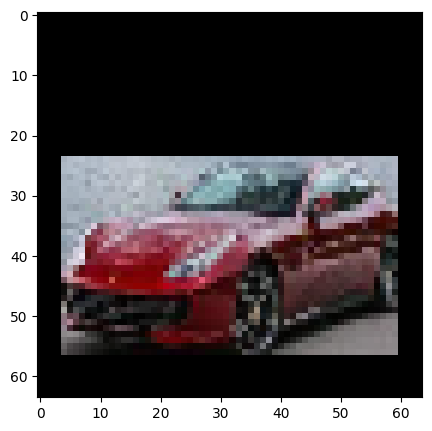


 new mask = (4, 24, 60, 57)



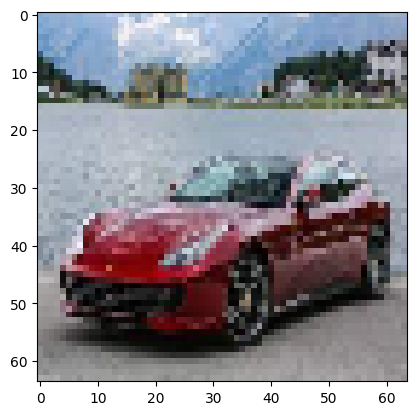

Shapes:
torch.Size([1, 256, 1, 1])
torch.Size([1, 256, 33, 56])
torch.Size([1, 256, 64, 64])
Embedds Check:


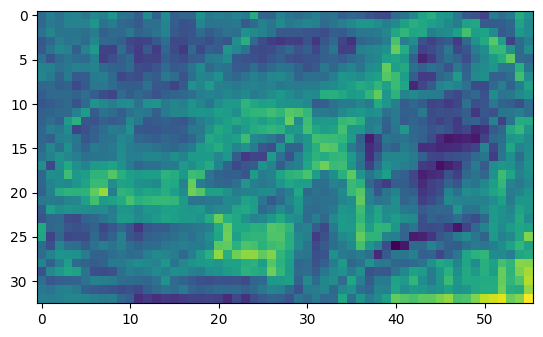

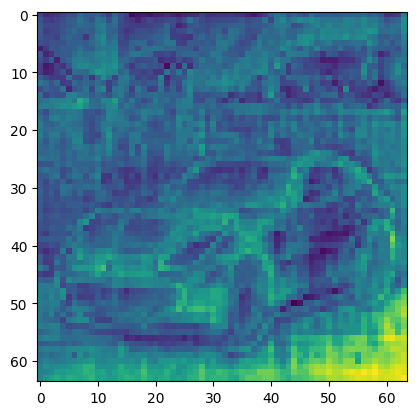

In [34]:
ferrari_img_em, (ferrari_mask_em, ferrari_mask_em_avg) = predictor.get_sam_embedds(cv2.resize(ferrari_img, ferrari_img_resize), morph_indexes(*ferrari_bbox, *ferrari_img.shape[:-1], *ferrari_img_resize))
plt.imshow(cv2.resize(ferrari_img, (64,64)))
plt.show()

print("Shapes:")
print(ferrari_mask_em_avg.shape)
print(ferrari_mask_em.shape)
print(ferrari_img_em.shape)

print("Embedds Check:")
plt.imshow(torch.squeeze(torch.mean(ferrari_mask_em, dim=1)).detach().cpu().numpy())
plt.show()
plt.imshow(torch.squeeze(torch.mean(ferrari_img_em, dim=1)).detach().cpu().numpy())
plt.show()

(168, 300, 3)


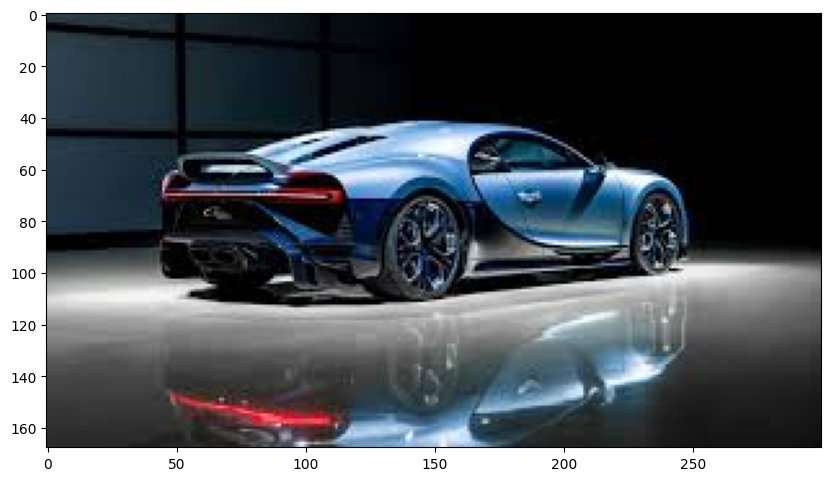

In [36]:
bugatti_img = load_image("assets/bugatti.jpg")

print(bugatti_img.shape)
plt.figure(figsize=(10,10))
plt.imshow(bugatti_img)

In [37]:
bugatti_img_resize = (300, 300)

In [38]:
bugatti_bbox = [50, 40, 250, 110]

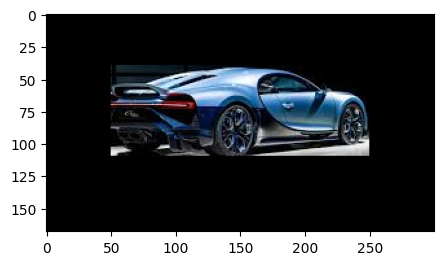

In [39]:
display_masked_image(bugatti_img, *bugatti_bbox)

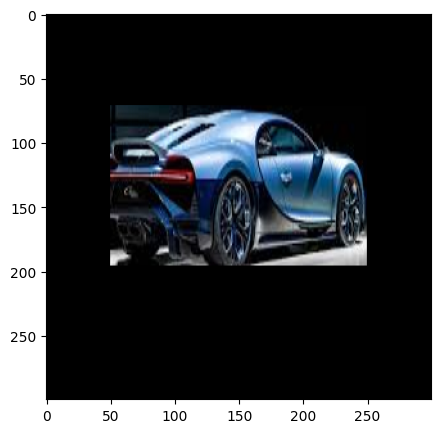

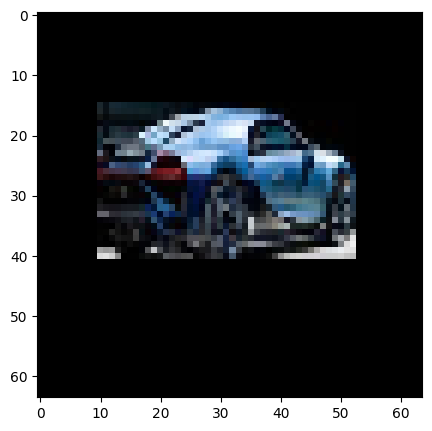


 new mask = (10, 15, 53, 41)



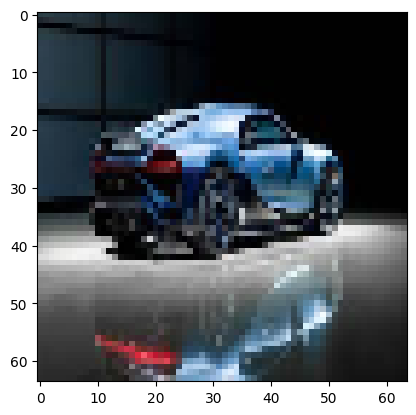

Shapes:
torch.Size([1, 256, 1, 1])
torch.Size([1, 256, 26, 43])
torch.Size([1, 256, 64, 64])
Embedds Check:


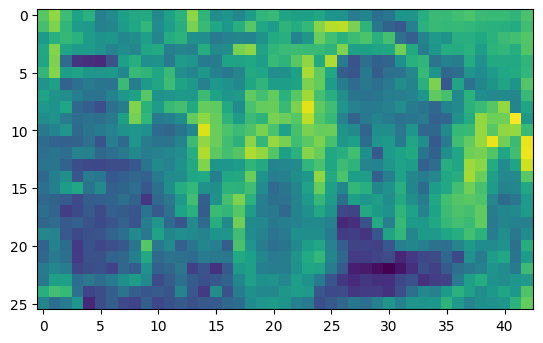

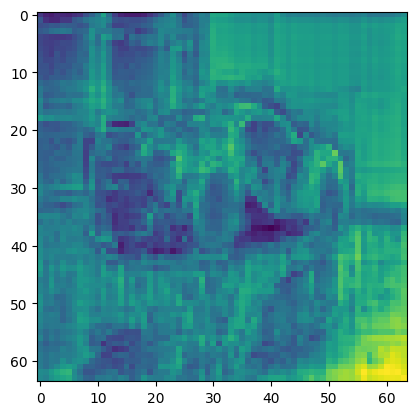

In [40]:
bugatti_img_em, (bugatti_mask_em, bugatti_mask_em_avg) = predictor.get_sam_embedds(cv2.resize(bugatti_img, bugatti_img_resize), morph_indexes(*bugatti_bbox, *bugatti_img.shape[:-1], *bugatti_img_resize))
plt.imshow(cv2.resize(bugatti_img, (64,64)))
plt.show()

print("Shapes:")
print(bugatti_mask_em_avg.shape)
print(bugatti_mask_em.shape)
print(bugatti_img_em.shape)

print("Embedds Check:")
plt.imshow(torch.squeeze(torch.mean(bugatti_mask_em, dim=1)).detach().cpu().numpy())
plt.show()
plt.imshow(torch.squeeze(torch.mean(bugatti_img_em, dim=1)).detach().cpu().numpy())
plt.show()

In [41]:
sim_map = torch.squeeze(cos_sim(ferrari_mask_em_avg, bugatti_mask_em_avg))

print(sim_map.shape)
print(sim_map.max(), sim_map.mean(), sim_map.min())

torch.Size([])
tensor(0.9284, device='cuda:0') tensor(0.9284, device='cuda:0') tensor(0.9284, device='cuda:0')


In [42]:
sim_map = torch.squeeze(cos_sim(ferrari_mask_em_avg, truck_mask_em_avg))

print(sim_map.shape)
print(sim_map.max(), sim_map.mean(), sim_map.min())

torch.Size([])
tensor(0.9320, device='cuda:0') tensor(0.9320, device='cuda:0') tensor(0.9320, device='cuda:0')


In [43]:
sim_map = torch.squeeze(cos_sim(bugatti_mask_em_avg, truck_mask_em_avg))

print(sim_map.shape)
print(sim_map.max(), sim_map.mean(), sim_map.min())

torch.Size([])
tensor(0.9415, device='cuda:0') tensor(0.9415, device='cuda:0') tensor(0.9415, device='cuda:0')


In [44]:
sim_map = torch.squeeze(cos_sim(ttire1_mask_em_avg, bugatti_img_em))

print(sim_map.shape)
print(sim_map.max(), sim_map.mean(), sim_map.min())

torch.Size([64, 64])
tensor(0.7982, device='cuda:0') tensor(0.4138, device='cuda:0') tensor(0.0487, device='cuda:0')


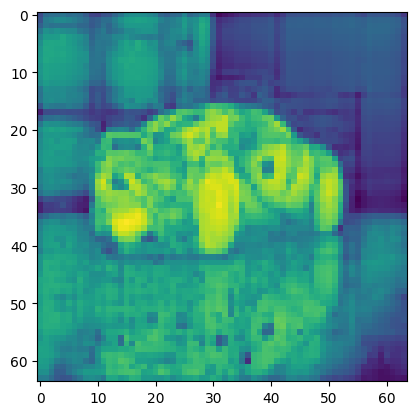

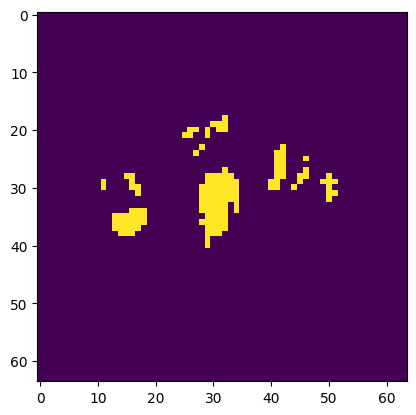

In [45]:
plt.imshow(sim_map.detach().cpu().numpy())
plt.show()

plt.imshow(sim_map.detach().cpu().numpy()>0.7)

## Bird and Car/Truck Experiments

(147, 147, 3)


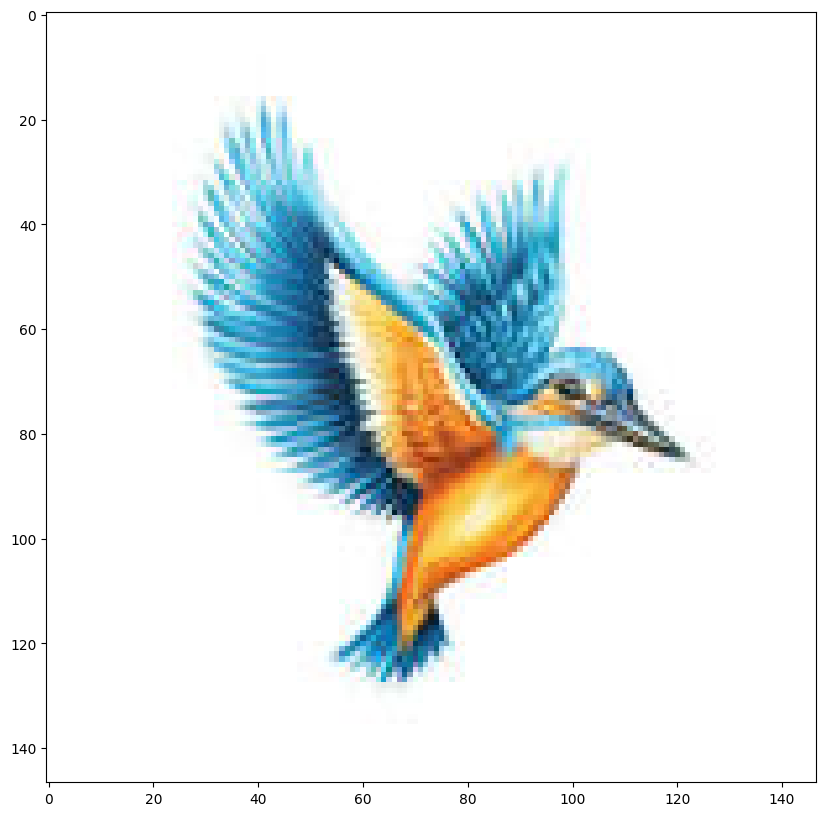

In [46]:
bird_img = load_image('assets/bird.jpg')
print(bird_img.shape)
plt.figure(figsize=(10,10))
plt.imshow(bird_img)

In [47]:
bird_img_resize = (147, 147)

In [48]:
bird_bbox = [25, 20, 120, 125]

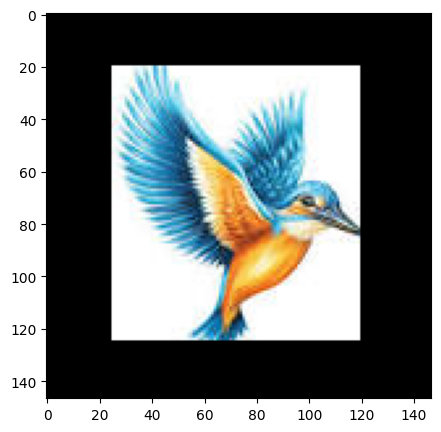

In [49]:
display_masked_image(bird_img, *bird_bbox)

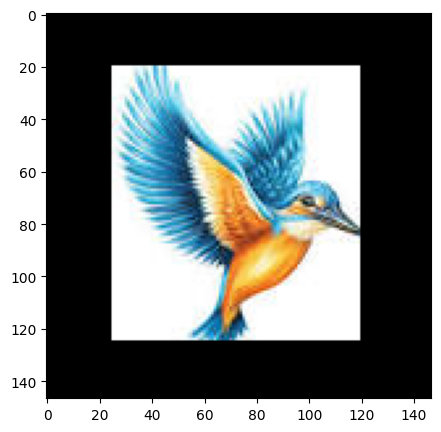

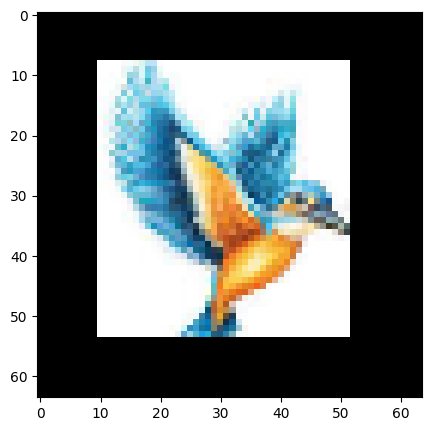


 new mask = (10, 8, 52, 54)



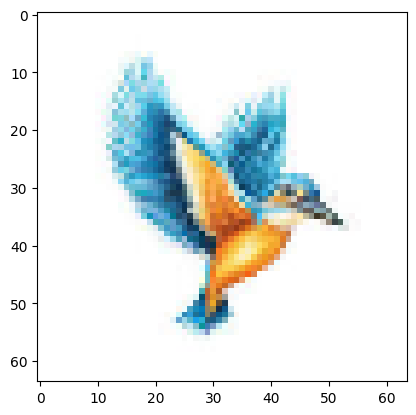

Shapes:
torch.Size([1, 256, 1, 1])
torch.Size([1, 256, 46, 42])
torch.Size([1, 256, 64, 64])
Embedds Check:


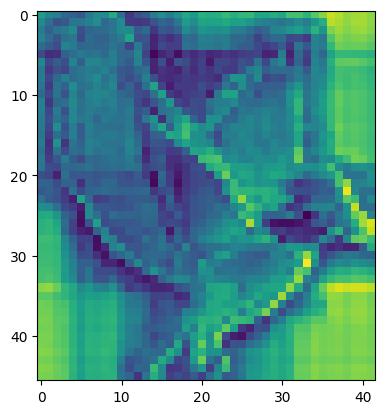

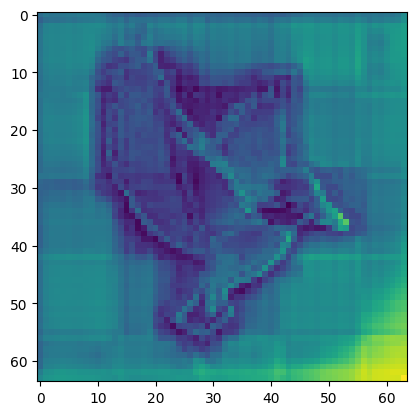

In [50]:
bird_img_em, (bird_mask_em, bird_mask_em_avg) = predictor.get_sam_embedds(cv2.resize(bird_img, bird_img_resize), morph_indexes(*bird_bbox, *bird_img.shape[:-1], *bird_img_resize))
plt.imshow(cv2.resize(bird_img, (64,64)))
plt.show()

print("Shapes:")
print(bird_mask_em_avg.shape)
print(bird_mask_em.shape)
print(bird_img_em.shape)

print("Embedds Check:")
plt.imshow(torch.squeeze(torch.mean(bird_mask_em, dim=1)).detach().cpu().numpy())
plt.show()
plt.imshow(torch.squeeze(torch.mean(bird_img_em, dim=1)).detach().cpu().numpy())
plt.show()

In [51]:
sim_map = torch.squeeze(cos_sim(bird_mask_em_avg, ferrari_mask_em_avg))

print(sim_map.shape)
print(sim_map.max(), sim_map.mean(), sim_map.min())

torch.Size([])
tensor(0.8480, device='cuda:0') tensor(0.8480, device='cuda:0') tensor(0.8480, device='cuda:0')


In [52]:
sim_map = torch.squeeze(cos_sim(bird_mask_em_avg, bugatti_mask_em_avg))

print(sim_map.shape)
print(sim_map.max(), sim_map.mean(), sim_map.min())

torch.Size([])
tensor(0.8037, device='cuda:0') tensor(0.8037, device='cuda:0') tensor(0.8037, device='cuda:0')


In [53]:
sim_map = torch.squeeze(cos_sim(bird_mask_em_avg, truck_mask_em_avg))

print(sim_map.shape)
print(sim_map.max(), sim_map.mean(), sim_map.min())

torch.Size([])
tensor(0.7434, device='cuda:0') tensor(0.7434, device='cuda:0') tensor(0.7434, device='cuda:0')
